In [1]:
import os
import torch
import clip
import torch.nn.functional as F
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from PIL import Image
import numpy as np

%matplotlib inline

def show(img):
    npimg = img.numpy()
    plt.figure(figsize = (100,40))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

os.environ["CUDA_VISIBLE_DEVICES"]="1"
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [2]:
torch.cuda.is_available()

True

In [38]:
folder = "outputs/grateful-energy-30grateful-energy-30-40pt-this_colorful_bird_has_a_yellow_breast,_with_a_black_crown_and_a_black_cheek_patch/"
num_images = 32

In [39]:
def prepro(im):
    return preprocess(Image.open(f"{folder}{im}.jpg")).unsqueeze(0).to(device)
    #return t(Image.open(f"{folder}{im}.jpg")).unsqueeze(0).to(device)

In [52]:
images = torch.cat(tuple([prepro(x) for x in range(num_images)]))
image = F.interpolate(images, size=224)
caption = "this colorful bird has a yellow breast, with a black crown and a black cheek patch"
text = clip.tokenize(caption).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    #print(logits_per_text)
    probs = logits_per_text.softmax(dim=-1).cpu().numpy()
print(np.mean(logits_per_text.cpu().numpy()))

27.89


In [50]:
t = transforms.ToTensor()
images = torch.stack(tuple([t(Image.open(f"{folder}{x}.jpg")) for x in range(num_images)]))
np_images = images.cpu().numpy()
scores = probs[0]

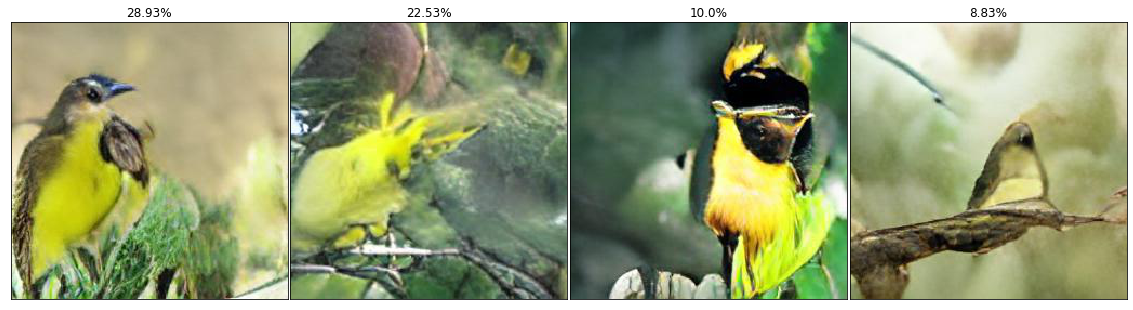

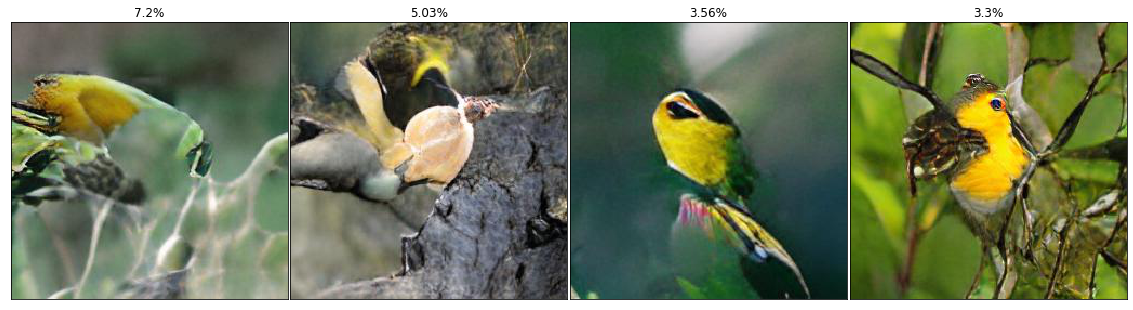

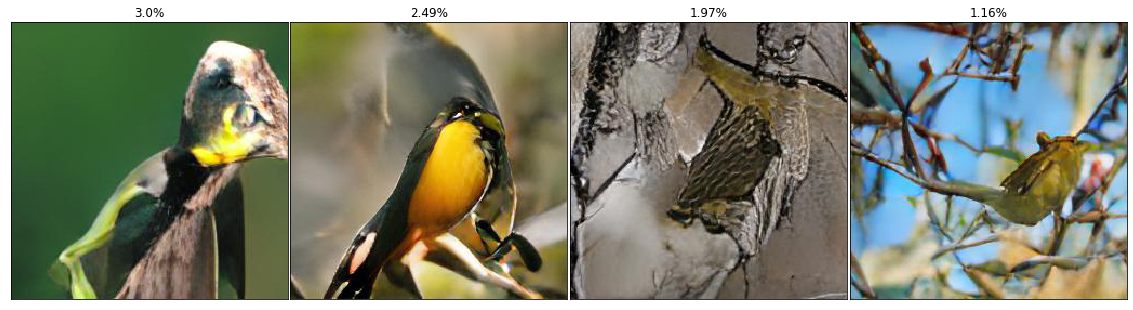

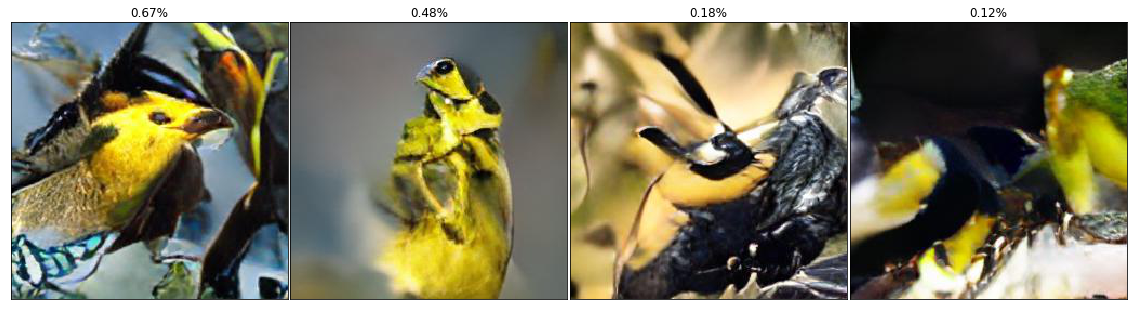

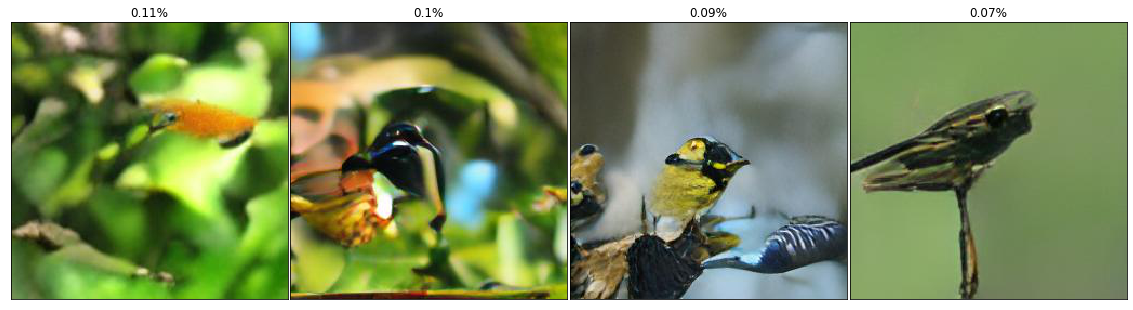

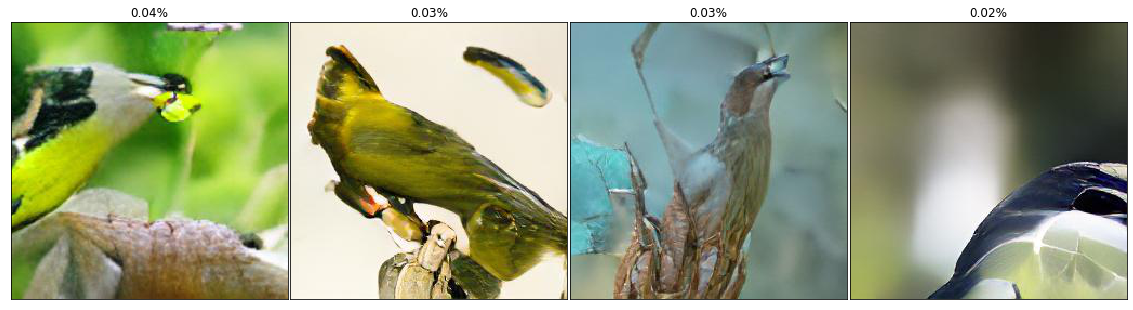

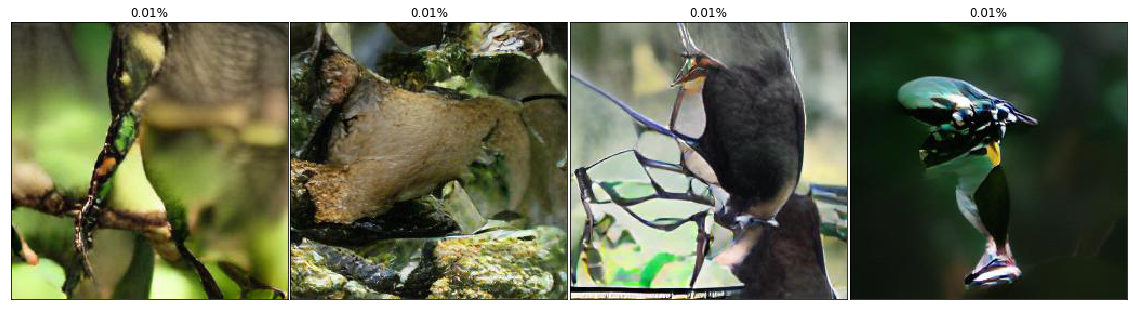

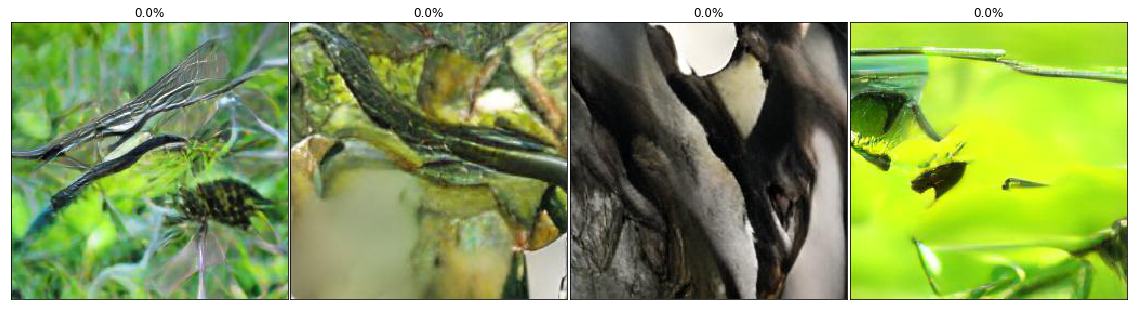

In [53]:
def show_reranking(images, scores, sort=True):
    img_shape = images.shape
    if sort:
        scores_sort = scores.argsort()
        scores = scores[scores_sort[::-1]]
        images = images[scores_sort[::-1]]

    rows = 4
    cols = img_shape[0] // 4
    img_idx = 0

    for col in range(cols):
        fig, axs = plt.subplots(1, rows, figsize=(20,20))
        plt.subplots_adjust(wspace=0.01)
        for row in range(rows):
            tran_img = np.transpose(images[img_idx], (1,2,0))
            #tran_img = images[img_idx]
            axs[row].imshow(tran_img, interpolation='nearest')
            axs[row].set_title("{}%".format(np.around(scores[img_idx]*100, 2)))
            axs[row].set_xticks([])
            axs[row].set_yticks([])
            img_idx += 1

show_reranking(np_images, scores)

In [66]:
import argparse
from pathlib import Path
from tqdm import tqdm

# torch

import torch

from einops import repeat

# vision imports

from PIL import Image
from torchvision.utils import make_grid, save_image

# dalle related classes and utils

from dalle_pytorch import DiscreteVAE, OpenAIDiscreteVAE, VQGanVAE1024, DALLE
from dalle_pytorch.tokenizer import tokenizer, HugTokenizer

import pandas as pd

# argument parsing

parser = argparse.ArgumentParser()

parser.add_argument('--dalle_path', type = str, required = True,
                    help='path to your trained DALL-E')

parser.add_argument('--text', type = str, required = False,
                    help='your text prompt')

parser.add_argument('--num_images', type = int, default = 128, required = False,
                    help='number of images')

parser.add_argument('--batch_size', type = int, default = 4, required = False,
                    help='batch size')

parser.add_argument('--top_k', type = float, default = 0.9, required = False,
                    help='top k filter threshold')

parser.add_argument('--outputs_dir', type = str, default = './outputs', required = False,
                    help='output directory')

parser.add_argument('--bpe_path', type = str,
                    help='path to your huggingface BPE json file')

parser.add_argument('--chinese', dest='chinese', action = 'store_true')

parser.add_argument('--taming', dest='taming', action='store_true')

args = parser.parse_args()

# helper fns

def exists(val):
    return val is not None

# tokenizer

if exists(args.bpe_path):
    tokenizer = HugTokenizer(args.bpe_path)
elif args.chinese:
    tokenizer = ChineseTokenizer()

# load DALL-E

dalle_path = Path(args.dalle_path)

assert dalle_path.exists(), 'trained DALL-E must exist'

load_obj = torch.load(str(dalle_path))
dalle_params, vae_params, weights = load_obj.pop('hparams'), load_obj.pop('vae_params'), load_obj.pop('weights')

dalle_params.pop('vae', None) # cleanup later

if vae_params is not None:
    vae = DiscreteVAE(**vae_params)
elif not args.taming:
    vae = OpenAIDiscreteVAE()
else:
    vae = VQGanVAE1024()


dalle = DALLE(vae = vae, **dalle_params).cuda()

dalle.load_state_dict(weights)

# generate images

image_size = vae.image_size

if exists(args.text):
    texts = args.text.split('|')
    for text in tqdm(texts):
        text = tokenizer.tokenize([args.text], dalle.text_seq_len).cuda()

        text = repeat(text, '() n -> b n', b = args.num_images)

        outputs = []

        for text_chunk in tqdm(text.split(args.batch_size), desc = f'generating images for - {text}'):
            output = dalle.generate_images(text_chunk, filter_thres = args.top_k)
            outputs.append(output)

        outputs = torch.cat(outputs)

        # save all images


        outputs_dir = Path(args.outputs_dir) / (args.dalle_path.replace('.','').replace('/','') + '-' + args.text.replace(' ', '_'))
        outputs_dir.mkdir(parents = True, exist_ok = True)

        for i, image in tqdm(enumerate(outputs), desc = 'saving images'):
            save_image(image, outputs_dir / f'{i}.jpg', normalize=True)

        print(f'created {args.num_images} images at "{str(outputs_dir)}"')
else:
    cap_df = pd.read_pickle("./cub_2011_test_captions.pkl")
    # generate images
    for i, row in cap_df.iterrows():
        temp_text = tokenize([row["caption"]], dalle.text_seq_len)#.cuda()  #,True,True).cuda()
        if i == 0:
            text = temp_text
            continue
        text = torch.cat((text, temp_text),0)
    
    def generate_batch(bb, text):
        outputs = []

        for text_chunk in tqdm(text.split(args.batch_size), desc = f'generating images for - {bb}'):
            output = dalle.generate_images(text_chunk, filter_thres = args.top_k)
            outputs.append(output)

        outputs = torch.cat(outputs)

        # save all images

        outputs_dir = Path(args.outputs_dir) / new_test_eval
        outputs_dir.mkdir(parents = True, exist_ok = True)

        for i, image in tqdm(enumerate(outputs), desc = 'saving images'):
            save_image(image, outputs_dir / f'{bb}-{i}.jpg', normalize=True)

        print(f'created {bb} images at "{str(outputs_dir)}"')

    big_batch = 30
    max_idx = len(text)  # non-inclusive
    print("len: ", max_idx)

    for bb in range(1000):
        s = bb*big_batch
        e = (bb+1)*big_batch
        if e > max_idx:
            e = max_idx
        generate_batch(bb, text[s:e].cuda())

ModuleNotFoundError: No module named 'taming.models'

In [73]:
import taming
taming.attributes()

AttributeError: module 'taming' has no attribute 'attributes'

In [67]:
!pip install taming-transformers